In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
# import covid infection data from germany
# obtained from Robert Koch Institut (RKI)
# data licensed under DL-DE->BY-2.0
# http://www.govdata.de/dl-de/by-2-0

df = pd.read_csv('RKI_COVID19.csv')
df.head()

,FID,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2
0,1,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/09/30 00:00:00,1001,"17.11.2020, 00:00 Uhr",0,-9,2020/09/30 00:00:00,0,1,0,Nicht übermittelt
1,2,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/10/29 00:00:00,1001,"17.11.2020, 00:00 Uhr",0,-9,2020/10/29 00:00:00,0,1,0,Nicht übermittelt
2,3,1,Schleswig-Holstein,SK Flensburg,A00-A04,M,1,0,2020/11/03 00:00:00,1001,"17.11.2020, 00:00 Uhr",0,-9,2020/11/03 00:00:00,1,1,0,Nicht übermittelt
3,4,1,Schleswig-Holstein,SK Flensburg,A00-A04,W,1,0,2020/08/24 00:00:00,1001,"17.11.2020, 00:00 Uhr",0,-9,2020/08/24 00:00:00,0,1,0,Nicht übermittelt
4,5,1,Schleswig-Holstein,SK Flensburg,A00-A04,W,1,0,2020/09/26 00:00:00,1001,"17.11.2020, 00:00 Uhr",0,-9,2020/09/26 00:00:00,0,1,0,Nicht übermittelt


In [4]:
#Translation of column names from german to english
df.rename(columns={"IdBundesland": "IdState", "Bundesland":"State", "Landkreis":"County", "Altersgruppe":"AgeGroup", 
                   "Geschlecht":"Sex", "AnzahlFall":"CaseNumber", "AnzahlTodesfall":"DeathNumber", 
                  "Meldedatum":"DateOfNotice", "IdLandkreis":"IdCounty", "Datenstand":"LastUpdated", 
                   "NeuerFall":"NewCase", "NeuerTodesfall":"NewDeath", "Refdatum":"ReferenceDate", "NeuGenesen":"NewRecovered", 
                   "AnzahlGenesen":"RecoveredNumber", "IstErkrankungsbeginn":"IsDayofSickening", "Altersgruppe2":"AgeGroup2"
                  }, inplace=True)

# drop redundant data and columns w/o relevant information for this project
try:
    df.drop(labels=["FID", "State", "County", "LastUpdated", "AgeGroup2", "NewCase", "NewDeath", "NewRecovered", "RecoveredNumber"], axis=1, inplace=True)
except Exception:
    pass

In [5]:
# IdState & IdCounty: Numerical IDs for state and county
# AgeGroup: binned ages of infected individuals
# CaseNumber/DeathNumber: Number of Cases/Deaths for this entry
# DateOfNotice: Date where federal agency (RKI, basically Germanys CDC) got notified of infection
# ReferenceDate: Either equal to DateofNotice; if not, then this is the date of disease start / symptom onset.
# IsDayofSickening: 1  if ReferenceDate equal symptom onset, 0 else. (strictly speaking, only redundant information)

df.head()

,IdState,AgeGroup,Sex,CaseNumber,DeathNumber,DateOfNotice,IdCounty,ReferenceDate,IsDayofSickening
0,1,A00-A04,M,1,0,2020/09/30 00:00:00,1001,2020/09/30 00:00:00,0
1,1,A00-A04,M,1,0,2020/10/29 00:00:00,1001,2020/10/29 00:00:00,0
2,1,A00-A04,M,1,0,2020/11/03 00:00:00,1001,2020/11/03 00:00:00,0
3,1,A00-A04,W,1,0,2020/08/24 00:00:00,1001,2020/08/24 00:00:00,0
4,1,A00-A04,W,1,0,2020/09/26 00:00:00,1001,2020/09/26 00:00:00,0


In [6]:
#change date strings to datetime
df['DateOfNotice'] = pd.to_datetime(df['DateOfNotice'], yearfirst=True)
df['ReferenceDate'] = pd.to_datetime(df['ReferenceDate'], yearfirst=True)
# replacing 'unbekannt'(unknown) for nan
df.replace('unbekannt', np.nan, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 481678 entries, 0 to 481677
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   IdState           481678 non-null  int64         
 1   AgeGroup          480049 non-null  object        
 2   Sex               477417 non-null  object        
 3   CaseNumber        481678 non-null  int64         
 4   DeathNumber       481678 non-null  int64         
 5   DateOfNotice      481678 non-null  datetime64[ns]
 6   IdCounty          481678 non-null  int64         
 7   ReferenceDate     481678 non-null  datetime64[ns]
 8   IsDayofSickening  481678 non-null  int64         
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 33.1+ MB


In [7]:
#dropping na due to low total number of nans
df.dropna(inplace=True)
df.shape

(476068, 9)

In [8]:
df.isna().sum()

IdState             0
AgeGroup            0
Sex                 0
CaseNumber          0
DeathNumber         0
DateOfNotice        0
IdCounty            0
ReferenceDate       0
IsDayofSickening    0
dtype: int64

In [9]:
df.describe()

,IdState,CaseNumber,DeathNumber,IdCounty,IsDayofSickening
count,476068.000000,476068.000000,476068.000000,476068.000000,476068.000000
mean,7.469427,1.696564,0.026879,7799.357550,0.669978
std,3.212134,2.829402,0.177719,3181.126812,0.470221
min,1.000000,-3.000000,-1.000000,1001.000000,0.000000
25%,5.000000,1.000000,0.000000,5513.000000,0.000000
50%,8.000000,1.000000,0.000000,8118.000000,1.000000
75%,9.000000,1.000000,0.000000,9463.000000,1.000000
max,16.000000,147.000000,8.000000,16077.000000,1.000000


,IdState,AgeGroup,Sex,CaseNumber,DeathNumber,DateOfNotice,IdCounty,ReferenceDate,IsDayofSickening
23,1,A15-A34,M,1,0,2020-03-14,1001,2020-03-16,1
137,1,A35-A59,M,1,0,2020-03-14,1001,2020-03-16,1
81,1,A15-A34,W,1,0,2020-03-14,1001,2020-03-12,1
178,1,A35-A59,W,1,0,2020-03-14,1001,2020-03-10,1
83,1,A15-A34,W,1,0,2020-03-18,1001,2020-03-15,1
...,...,...,...,...,...,...,...,...,...
22,1,A05-A14,W,2,0,2020-11-13,1001,2020-11-13,0
176,1,A35-A59,M,1,0,2020-11-13,1001,2020-11-13,0
136,1,A15-A34,W,1,0,2020-11-14,1001,2020-11-11,1
229,1,A35-A59,W,1,0,2020-11-15,1001,2020-11-11,1


,IdState,CaseNumber,DeathNumber,IdCounty,IsDayofSickening
count,250.0,250.000000,250.000000,250.0,250.000000
mean,1.0,1.100000,0.012000,1001.0,0.568000
std,0.0,0.338316,0.109104,0.0,0.496348
min,1.0,1.000000,0.000000,1001.0,0.000000
25%,1.0,1.000000,0.000000,1001.0,0.000000
50%,1.0,1.000000,0.000000,1001.0,1.000000
75%,1.0,1.000000,0.000000,1001.0,1.000000
max,1.0,3.000000,1.000000,1001.0,1.000000


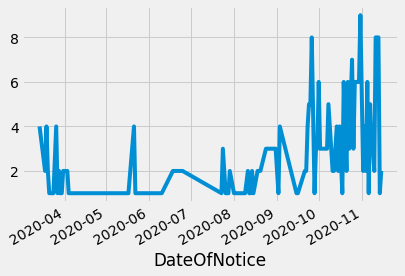

In [10]:
#infection dynamics for state 1
display(df[df['IdCounty']==1001].sort_values(['DateOfNotice']))
df[df['IdCounty']==1001].groupby('DateOfNotice', axis=0).sum()['CaseNumber'].plot()

df[df['IdCounty']==1001].describe()

In [11]:
#compile time series of new Cases by DateOfNotice, rolling 7 day average.
ds_casenum = df.groupby('DateOfNotice', axis=0).sum()['CaseNumber'].rolling(window=7, center=True).mean()
ds_casenum_sickening = df[df['IsDayofSickening']==1].groupby('DateOfNotice', axis=0).sum()['CaseNumber'].rolling(window=7, center=True).mean()

In [12]:
#compile time series of new Cases by ReferenceDate, rolling 7 day average. Only include cases where symptom onset is known.
ds_casenumref = df[df['IsDayofSickening']==1].groupby('ReferenceDate', axis=0) \
                .sum()['CaseNumber'].rolling(window=7, center=True).mean()

#compile time series of new Deaths by DateOfNotice, rolling 7 day average.
#ds_deathnum = df.groupby('DateOfNotice', axis=0).sum()['DeathNumber'].rolling(window=7, center=True).mean()

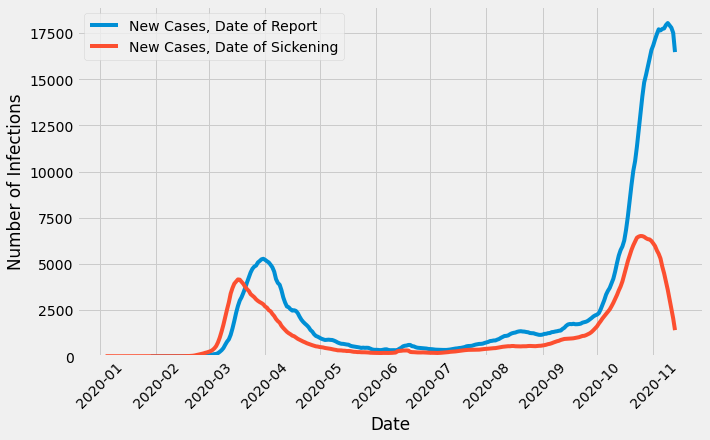

In [13]:
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(ds_casenum.index, ds_casenum, label='New Cases, Date of Report')
ax.plot(ds_casenumref.index, ds_casenumref, label='New Cases, Date of Sickening')
ax.set_ylim(bottom=0)
ax.set_xlabel('Date')
ax.tick_params(axis='x', rotation=45)
ax.set_ylabel('Number of Infections')
ax.legend()

In [14]:
#df.groupby('IdCounty').head()

In [15]:
df_sub = df[df['IsDayofSickening']==1]
LagOfNotice = df_sub.apply(lambda row: row.DateOfNotice - row.ReferenceDate, axis=1)
df_sub = df_sub.assign(LagOfNotice = LagOfNotice.values)


In [16]:
# Data where delay between Sickening and Notice was over 1 month were excluded.
# In June and July, where cases were lowest, the delay of notice was lowest, too.

months_single = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']

for i, m in enumerate(months_single):
    delay = df_sub[(df_sub['DateOfNotice'].dt.month==i+1) & (df_sub['LagOfNotice'].dt.days < 32)]['LagOfNotice'].mean()
    print('The average delay between day of sickening and day of report for cases reported in {} was {}'.format(m, delay))

The average delay between day of sickening and day of report for cases reported in January was 4 days 00:00:00
The average delay between day of sickening and day of report for cases reported in February was 3 days 01:41:38.823529411
The average delay between day of sickening and day of report for cases reported in March was 6 days 09:54:49.032698916
The average delay between day of sickening and day of report for cases reported in April was 6 days 15:51:59.198664440
The average delay between day of sickening and day of report for cases reported in May was 4 days 21:31:22.915451895
The average delay between day of sickening and day of report for cases reported in June was 4 days 10:35:52.048450302
The average delay between day of sickening and day of report for cases reported in July was 4 days 09:17:36.924294381
The average delay between day of sickening and day of report for cases reported in August was 4 days 12:19:13.337202553
The average delay between day of sickening and day of re

In [17]:
# import county information. can be merged with df using 'IdCounty'
# using the county_information_df, we can extract cases per 100k
# and possible relationship between numbers of cases and population density
county_information_df = pd.read_csv('RKI_Corona_Landkreise.csv')
county_information_df=county_information_df[['RS', 'BEZ', 'EWZ', 'county', 'SHAPE_Area']]
county_information_df.rename(columns={'RS': 'IdCounty', 'BEZ':'CountyType', 'EWZ': 'Population', 'SHAPE_Area': 'Area'}, inplace=True)
county_information_df.head()

,IdCounty,CountyType,Population,county,Area
0,1001,Kreisfreie Stadt,90164,SK Flensburg,0.006873
1,1002,Kreisfreie Stadt,246794,SK Kiel,0.015507
2,1003,Kreisfreie Stadt,216530,SK Lübeck,0.028928
3,1004,Kreisfreie Stadt,80196,SK Neumünster,0.009808
4,1051,Kreis,133193,LK Dithmarschen,0.196087


In [18]:
county_information_df.set_index('IdCounty', inplace=True)
pop_density = county_information_df['Population']/county_information_df['Area']
county_information_df['PopDensity'] = pop_density

In [19]:
county_information_df.head()

,CountyType,Population,county,Area,PopDensity
IdCounty,,,,,
1001,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07
1002,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07
1003,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06
1004,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06
1051,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05


In [20]:
#df= df.set_index('IdCounty')
df_sum_county = df.groupby(['IdCounty'])[['CaseNumber', 'DeathNumber', 'AgeGroup']].sum()

merge_county_df = df_sum_county.merge(county_information_df, left_index=True, right_index=True)
merge_county_df[['CasePer100k']] = merge_county_df['CaseNumber']/merge_county_df['Population']*1e5
merge_county_df[['DeathPer100k']] = merge_county_df['DeathNumber']/merge_county_df['Population']*1e5

merge_county_df.head()

,CaseNumber,DeathNumber,CountyType,Population,county,Area,PopDensity,CasePer100k,DeathPer100k
IdCounty,,,,,,,,,
1001,275,3,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07,304.999778,3.327270
1002,936,16,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07,379.263677,6.483140
1003,966,5,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06,446.127557,2.309149
1004,376,4,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06,468.851314,4.987780
1051,501,13,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05,376.145894,9.760273


,CaseNumber,DeathNumber,Population,Area,PopDensity,CasePer100k,DeathPer100k
CaseNumber,1.000000,0.831683,0.924605,-0.119569,0.449955,0.500271,0.107393
DeathNumber,0.831683,1.000000,0.764118,-0.031338,0.197535,0.509488,0.501603
Population,0.924605,0.764118,1.000000,0.035303,0.341415,0.237634,-0.030695
Area,-0.119569,-0.031338,0.035303,1.000000,-0.429705,-0.352709,-0.091921
PopDensity,0.449955,0.197535,0.341415,-0.429705,1.000000,0.372880,-0.054850
CasePer100k,0.500271,0.509488,0.237634,-0.352709,0.372880,1.000000,0.548280
DeathPer100k,0.107393,0.501603,-0.030695,-0.091921,-0.054850,0.548280,1.000000


There seems to be a significant correlation between population density and number of cases per 100k.
No correlation found between population density and number of deaths per 100k.


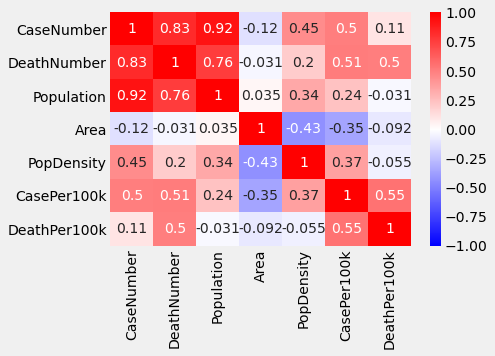

In [21]:
display(merge_county_df.corr())
sns.heatmap(merge_county_df.corr(), vmin=-1., vmax=1., cmap='bwr', annot=True)
print('There seems to be a significant correlation between population density and number of cases per 100k.')
print('No correlation found between population density and number of deaths per 100k.')

In [22]:
df= df.set_index('IdCounty')
df_sum = df.groupby(['IdCounty', 'AgeGroup', 'Sex'])[['CaseNumber', 'DeathNumber', 'AgeGroup']].sum()
df_sum.head(20)

CaseNumber  DeathNumber
IdCounty AgeGroup Sex                         
1001     A00-A04  M             3            0
                  W             3            0
         A05-A14  M             5            0
                  W            14            0
         A15-A34  M            62            0
                  W            61            0
         A35-A59  M            46            0
                  W            61            0
         A60-A79  M             9            2
                  W             8            0
         A80+     M             2            1
                  W             1            0
1002     A00-A04  M             6            0
                  W             9            0
         A05-A14  M            32            0
                  W            34            0
         A15-A34  M           186            0
                  W           167            0
         A35-A59  M           157            0
                  W           174            0

In [23]:
df_unstack = df_sum.unstack().unstack()
death_sum = df_unstack['DeathNumber'].sum(axis=1)
df_unstack = df_unstack.drop(labels=['DeathNumber'], axis=1)
df_unstack.columns = ['_'.join(col).strip('_') for col in df_unstack.columns]
df_unstack['death_sum'] = death_sum
df_unstack.fillna(0, inplace=True)
df_unstack.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum
IdCounty,,,,,,,,,,,,,
1001,3.0,5.0,62.0,46.0,9.0,2.0,3.0,14.0,61.0,61.0,8.0,1.0,3.0
1002,6.0,32.0,186.0,157.0,61.0,13.0,9.0,34.0,167.0,174.0,67.0,30.0,16.0
1003,9.0,36.0,210.0,182.0,55.0,14.0,12.0,33.0,178.0,174.0,48.0,15.0,5.0
1004,9.0,23.0,71.0,74.0,18.0,3.0,8.0,11.0,59.0,70.0,21.0,9.0,4.0
1051,6.0,19.0,71.0,76.0,54.0,23.0,8.0,21.0,72.0,74.0,58.0,19.0,13.0


In [24]:
merge_df = df_unstack.merge(county_information_df, left_index=True, right_index=True)#'IdCounty')#True)#on='IdCounty')
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,CountyType,Population,county,Area,PopDensity
IdCounty,,,,,,,,,,,,,,,,,,
1001,3.0,5.0,62.0,46.0,9.0,2.0,3.0,14.0,61.0,61.0,8.0,1.0,3.0,Kreisfreie Stadt,90164,SK Flensburg,0.006873,1.311911e+07
1002,6.0,32.0,186.0,157.0,61.0,13.0,9.0,34.0,167.0,174.0,67.0,30.0,16.0,Kreisfreie Stadt,246794,SK Kiel,0.015507,1.591517e+07
1003,9.0,36.0,210.0,182.0,55.0,14.0,12.0,33.0,178.0,174.0,48.0,15.0,5.0,Kreisfreie Stadt,216530,SK Lübeck,0.028928,7.485261e+06
1004,9.0,23.0,71.0,74.0,18.0,3.0,8.0,11.0,59.0,70.0,21.0,9.0,4.0,Kreisfreie Stadt,80196,SK Neumünster,0.009808,8.176284e+06
1051,6.0,19.0,71.0,76.0,54.0,23.0,8.0,21.0,72.0,74.0,58.0,19.0,13.0,Kreis,133193,LK Dithmarschen,0.196087,6.792530e+05


In [25]:
merge_df = merge_df.drop(['county'], axis=1)
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,CountyType,Population,Area,PopDensity
IdCounty,,,,,,,,,,,,,,,,,
1001,3.0,5.0,62.0,46.0,9.0,2.0,3.0,14.0,61.0,61.0,8.0,1.0,3.0,Kreisfreie Stadt,90164,0.006873,1.311911e+07
1002,6.0,32.0,186.0,157.0,61.0,13.0,9.0,34.0,167.0,174.0,67.0,30.0,16.0,Kreisfreie Stadt,246794,0.015507,1.591517e+07
1003,9.0,36.0,210.0,182.0,55.0,14.0,12.0,33.0,178.0,174.0,48.0,15.0,5.0,Kreisfreie Stadt,216530,0.028928,7.485261e+06
1004,9.0,23.0,71.0,74.0,18.0,3.0,8.0,11.0,59.0,70.0,21.0,9.0,4.0,Kreisfreie Stadt,80196,0.009808,8.176284e+06
1051,6.0,19.0,71.0,76.0,54.0,23.0,8.0,21.0,72.0,74.0,58.0,19.0,13.0,Kreis,133193,0.196087,6.792530e+05


In [26]:
# Dummy the categorical variables
cat_vars = merge_df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
# for each cat add dummy var, drop original column
    merge_df = pd.concat([merge_df.drop(var, axis=1), pd.get_dummies(merge_df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [27]:
merge_df.head()

,CaseNumber_M_A00-A04,CaseNumber_M_A05-A14,CaseNumber_M_A15-A34,CaseNumber_M_A35-A59,CaseNumber_M_A60-A79,CaseNumber_M_A80+,CaseNumber_W_A00-A04,CaseNumber_W_A05-A14,CaseNumber_W_A15-A34,CaseNumber_W_A35-A59,CaseNumber_W_A60-A79,CaseNumber_W_A80+,death_sum,Population,Area,PopDensity,CountyType_Kreis,CountyType_Kreisfreie Stadt,CountyType_Landkreis,CountyType_Stadtkreis
IdCounty,,,,,,,,,,,,,,,,,,,,
1001,3.0,5.0,62.0,46.0,9.0,2.0,3.0,14.0,61.0,61.0,8.0,1.0,3.0,90164,0.006873,1.311911e+07,0,1,0,0
1002,6.0,32.0,186.0,157.0,61.0,13.0,9.0,34.0,167.0,174.0,67.0,30.0,16.0,246794,0.015507,1.591517e+07,0,1,0,0
1003,9.0,36.0,210.0,182.0,55.0,14.0,12.0,33.0,178.0,174.0,48.0,15.0,5.0,216530,0.028928,7.485261e+06,0,1,0,0
1004,9.0,23.0,71.0,74.0,18.0,3.0,8.0,11.0,59.0,70.0,21.0,9.0,4.0,80196,0.009808,8.176284e+06,0,1,0,0
1051,6.0,19.0,71.0,76.0,54.0,23.0,8.0,21.0,72.0,74.0,58.0,19.0,13.0,133193,0.196087,6.792530e+05,1,0,0,0


In [28]:
X = merge_df.drop('death_sum', axis=1)
y = merge_df['death_sum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


In [29]:
lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit

LinearRegression(normalize=True)

In [30]:
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print('Test R2 score of linear regression model is {}'.format(test_score))
print('Train R2 score of linear regression model is {}'.format(train_score))

Test R2 score of linear regression model is 0.8456503130196313
Train R2 score of linear regression model is 0.8391372871089122


In [31]:
# Alternatively, we can predict deaths by simple calculations using the known age- and sex-dependent death rate
# The death rate was calculated using the full age and sex-dependent data.
# In contrast to that, the linear regression model was fed by the total death number (in the training data set),
#     without knowing its age- and sex-dependency
death_rate_df = df.groupby(['AgeGroup', 'Sex'])[['CaseNumber', 'DeathNumber']].sum()
death_rate = death_rate_df['DeathNumber']/death_rate_df['CaseNumber']
death_rate_df['DeathRate'] = death_rate
death_rate_df

CaseNumber  DeathNumber  DeathRate
AgeGroup Sex                                    
A00-A04  M          8046            0   0.000000
         W          7339            2   0.000273
A05-A14  M         24647            1   0.000041
         W         22863            0   0.000000
A15-A34  M        137720           17   0.000123
         W        129829            7   0.000054
A35-A59  M        153878          417   0.002710
         W        157932          165   0.001045
A60-A79  M         57142         2712   0.047461
         W         55116         1217   0.022081
A80+     M         19167         3946   0.205875
         W         34001         4312   0.126820

<AxesSubplot:xlabel='AgeGroup,Sex'>

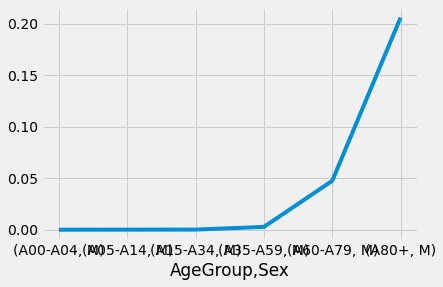

In [51]:
death_rate_df.loc[(slice(None),'M'), :]['DeathRate'].plot()

In [32]:
# manual calculation of predicted deaths using death_rate_df and df_sum
df_sum_predict = df_sum.astype('float32').copy()
df_sum_predict[['DeathNumber']] = 0.

for c in np.unique(np.array(df_sum_predict.index.tolist())[:,0]):
    for a in np.unique(np.array(df_sum_predict.index.tolist())[:,1]):
        for s in np.unique(np.array(df_sum_predict.index.tolist())[:,2]):
            try:
                df_sum_predict.loc[(int(c), a, s)]['DeathNumber'] += float(death_rate_df.loc[(a, s)]['DeathRate'] * df_sum_predict.loc[(int(c), a, s)]['CaseNumber'])
            except KeyError:
                continue

In [33]:
df_sum_predict.head()

CaseNumber  DeathNumber
IdCounty AgeGroup Sex                         
1001     A00-A04  M           3.0     0.000000
                  W           3.0     0.000818
         A05-A14  M           5.0     0.000203
                  W          14.0     0.000000
         A15-A34  M          62.0     0.007653

In [34]:
#calculation of y vector to quickly compare results to our complicated linear regression model. 
#same test/train split (after calculation/prediction, using the prediction y vector!!) to compare results, even though it's obv. not needed here.

df_sum_predict_unstack = df_sum_predict.unstack().unstack()
death_sum_predict = df_sum_predict_unstack['DeathNumber'].sum(axis=1)

y_simple_predict = death_sum_predict.values
_, _, y_train_simple, y_test_simple = train_test_split(X, y_simple_predict, test_size=.3, random_state=42)

In [35]:
#Score using your model
test_score_simple = r2_score(y_test, y_test_simple)
train_score_simple = r2_score(y_train, y_train_simple)
print('Test R2 score of linear regression model was {}'.format(test_score))
print('Train R2 score of linear regression model was {}'.format(train_score))

print('Test R2 score from the test set of the simple calculation was {}'.format(test_score_simple))
print('Train R2 score from the train set of the simple calculation was {}'.format(train_score_simple))
print('\n No significant differences between the predictions.')

Test R2 score of linear regression model was 0.8456503130196313
Train R2 score of linear regression model was 0.8391372871089122
Test R2 score from the test set of the simple calculation was 0.8738966697166358
Train R2 score from the train set of the simple calculation was 0.7879757026554679

 No significant differences between the predictions.
